In [0]:
import os
import json
import pathlib
import shutil
import tarfile
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend

from sklearn.model_selection import train_test_split

import matplotlib
from matplotlib import pyplot as plt

from google.colab import drive

In [0]:
%load_ext tensorboard

In [0]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
colab = 1

In [0]:
if colab == 1:
  working_dir = 'drive/My Drive/Colab_Live_Project_Surface_Water/'
else:
  workding_dir = ''

image_dir = 'drive/My Drive/Colab_Live_Project_Surface_Water/Data_Module_4/'

In [0]:
input_images_dir = image_dir + 'NWPU/Train/Images/'
input_masks_dir = image_dir + 'NWPU/Train/Masks/'
test_images_dir = image_dir + 'NWPU/Test/Images/'
test_masks_dir = image_dir + 'NWPU/Test/Masks/'

In [0]:
TARGET_WIDTH = TARGET_HEIGHT = 128
BATCH_SIZE = 10

In [0]:
def clip_mask(msk):
  msk[msk < 100] = 0
  msk[msk >= 100] = 255
  return msk

In [0]:
train_data_args = dict(shear_range=0,
                       zoom_range=0,
                       rotation_range=90,
                       rescale=1./255,
                       horizontal_flip=True)

train_mask_args =  dict(shear_range=0,
                        zoom_range=0,
                        rotation_range=90,
                        rescale=1./255,
                        preprocessing_function=clip_mask,
                        horizontal_flip=True)

test_data_args = dict(rescale=1./255)
test_mask_args = dict(rescale=1./255, preprocessing_function=clip_mask)

train_datagen = ImageDataGenerator(**train_data_args)
train_maskgen = ImageDataGenerator(**train_mask_args)

test_datagen = ImageDataGenerator(**test_data_args)
test_maskgen = ImageDataGenerator(**test_mask_args)

In [0]:
def create_generators_for_input(train_images_dir, train_masks_dir,
                                test_images_dir, test_masks_dir):
  
  img_generator = train_datagen.flow_from_directory(train_images_dir,
                                                    target_size=(TARGET_WIDTH, TARGET_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode=None, 
                                                    seed=111, 
                                                    shuffle=False)

  mask_generator = train_maskgen.flow_from_directory(train_masks_dir,
                                                     target_size=(TARGET_WIDTH, TARGET_HEIGHT),
                                                     color_mode = 'grayscale',
                                                     batch_size=BATCH_SIZE,
                                                     class_mode=None, 
                                                     seed=111, 
                                                    shuffle=False)

  test_img_generator = test_datagen.flow_from_directory(test_images_dir,
                                                        target_size=(TARGET_WIDTH, TARGET_HEIGHT),
                                                        batch_size=BATCH_SIZE,
                                                        class_mode=None, 
                                                        seed=111,
                                                        shuffle=False)

  test_mask_generator = test_maskgen.flow_from_directory(test_masks_dir,
                                                         target_size=(TARGET_WIDTH, TARGET_HEIGHT),
                                                         color_mode = 'grayscale',
                                                         batch_size=BATCH_SIZE,
                                                         class_mode=None, 
                                                         seed=111,
                                                         shuffle=False)

  train_generator = (pair for pair in zip(img_generator, mask_generator))
  test_generator = (pair for pair in zip(test_img_generator, test_mask_generator))
  return train_generator, test_generator

In [0]:
train_generator, test_generator = create_generators_for_input(input_images_dir, 
                                                              input_masks_dir, 
                                                              test_images_dir, 
                                                              test_masks_dir)

Found 489 images belonging to 1 classes.
Found 489 images belonging to 1 classes.
Found 163 images belonging to 1 classes.
Found 163 images belonging to 1 classes.


In [0]:
def pair_image_with_mask(img, mask):
    mask = mask.squeeze()
    mask = np.stack((mask,)*3, axis=-1)
    return np.concatenate([img, mask], axis = 1)

In [0]:
def show_combined_plots(x, y, batch_sz, fsize):
  cols = 2
  rows = batch_sz//cols
  _, axs = plt.subplots(rows, cols, figsize = fsize)
  axs = axs.flatten()
  for i in range (0, batch_sz):
    combined = pair_image_with_mask(x[i], y[i])
    axs[i].axis('off')
    axs[i].imshow(combined)

  plt.tight_layout()

In [0]:
img, msk = next(test_generator)

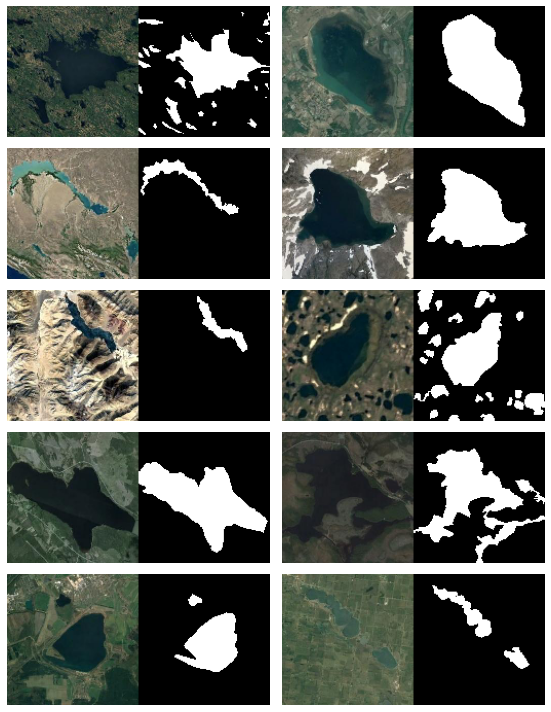

In [0]:
show_combined_plots(img, msk, BATCH_SIZE, (8, 10))

In [0]:
def mean_iou_imp(y_true, y_pred):
  i = backend.sum(backend.abs(y_true*y_pred), axis = -1)
  u = backend.sum(y_true, axis = -1) + backend.sum(y_pred, axis = -1) - i
  iou = backend.mean((i+1)/(u+1), axis = 0)
  return iou

In [0]:
class unet():
    def __init__(self):
        inputs = Input((TARGET_HEIGHT, TARGET_HEIGHT, 3))
        _tensor = inputs

        f = 64
        layers = []

        for i in range(0, 4):
            _tensor = Conv2D(f, 3, activation = 'relu', padding = 'same')(_tensor)
            _tensor = Conv2D(f, 3, activation = 'relu', padding = 'same')(_tensor)
            layers.append(_tensor)
            _tensor = MaxPooling2D()(_tensor)
            f = f*2

        ff2 = 1024
        j = len(layers)-1
        _tensor = Conv2D(f, 3, activation = 'relu', padding = 'same')(_tensor)
        _tensor = Conv2D(f, 3, activation = 'relu', padding = 'same')(_tensor)
        _tensor = Conv2DTranspose(ff2, 2, strides = (2, 2), padding = 'same')(_tensor)
        
        _tensor = Concatenate(axis = 3)([_tensor, layers[j]])
        j = j-1
  
        for i in range(0, 3):
            ff2 = ff2//2
            f = f//2
            _tensor = Conv2D(f, 3, activation = 'relu', padding = 'same')(_tensor)
            _tensor = Conv2D(f, 3, activation = 'relu', padding = 'same')(_tensor)
            _tensor = Conv2DTranspose(ff2, 2, strides = (2, 2), padding = 'same')(_tensor)
            _tensor = Concatenate(axis = 3)([_tensor, layers[j]])          
            j = j - 1

        _tensor = Conv2D(f, 3, activation = 'relu', padding = 'same')(_tensor)
        _tensor = Conv2D(f, 3, activation = 'relu', padding = 'same')(_tensor)
 
        outputs = Conv2D(1, 1, activation = 'sigmoid')(_tensor)
 
        self._model = Model(inputs, outputs)
        self._model.compile(optimizer='adam', 
                            loss='binary_crossentropy',
                            metrics = [mean_iou_imp])

    def train(self, train_gen, test_gen, batch, e, steps, vsteps, callbacks):
      self.history = self._model.fit(train_gen,
                                     verbose = 1,
                                     callbacks = callbacks,
                                     validation_data = test_gen,
                                     batch_size = batch,
                                     epochs = e,
                                     steps_per_epoch = steps,
                                     validation_steps = vsteps
                                     )

In [0]:
unet_model = unet()

In [0]:
unet_model._model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [0]:
pickle_path = working_dir + 'unet_model.h5'
nwpu_logs_dir = working_dir + 'logs/fit/nwpu/'

In [0]:
epoch = 20
steps_per_epoch = 10
vsteps = 10

checkpoint = ModelCheckpoint(pickle_path, 
                             monitor = 'val_loss', 
                             mode = 'min', 
                             verbose = 1, 
                             save_best_only = True)

early_stop_condition = EarlyStopping(monitor = 'val_loss', 
                                     mode = 'min',
                                     verbose = 1, 
                                     patience = 3)

tboard = TensorBoard(log_dir = nwpu_logs_dir)

cb = [early_stop_condition, checkpoint, tboard]

In [0]:
%%time
unet_model.train(train_generator, test_generator, 
                 BATCH_SIZE, 
                 epoch, steps_per_epoch, vsteps, 
                 cb)

Epoch 1/20
10/10 [==============================] - ETA: 0s - loss: 0.8587 - mean_iou_imp: 0.7560 
Epoch 00001: val_loss improved from inf to 0.52921, saving model to drive/My Drive/Colab_Live_Project_Surface_Water/unet_model.h5
10/10 [==============================] - 262s 26s/step - loss: 0.8587 - mean_iou_imp: 0.7560 - val_loss: 0.5292 - val_mean_iou_imp: 0.7349
Epoch 2/20
10/10 [==============================] - ETA: 0s - loss: 0.4553 - mean_iou_imp: 0.8004 
Epoch 00002: val_loss improved from 0.52921 to 0.35056, saving model to drive/My Drive/Colab_Live_Project_Surface_Water/unet_model.h5
10/10 [==============================] - 256s 26s/step - loss: 0.4553 - mean_iou_imp: 0.8004 - val_loss: 0.3506 - val_mean_iou_imp: 0.8677
Epoch 3/20
10/10 [==============================] - ETA: 0s - loss: 0.3896 - mean_iou_imp: 0.8600 
Epoch 00003: val_loss improved from 0.35056 to 0.29577, saving model to drive/My Drive/Colab_Live_Project_Surface_Water/unet_model.h5
10/10 [====================

In [0]:
X_test, y_test = next(test_generator)

In [0]:
y_pred = unet_model._model.predict(X_test)

In [0]:
y_pred.shape

(10, 128, 128, 1)

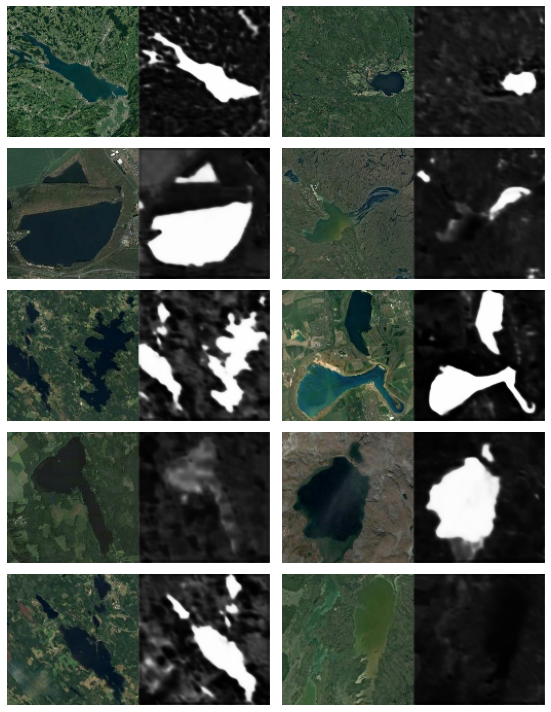

In [0]:
show_combined_plots(X_test, y_pred, BATCH_SIZE, (8, 10))

In [0]:
s2_input_images_dir = image_dir + 'S2_Cloudless/Train/Images/'
s2_input_masks_dir = image_dir + 'S2_Cloudless/Train/Masks/'
s2_test_images_dir = image_dir + 'S2_Cloudless/Test/Images/'
s2_test_masks_dir = image_dir + 'S2_Cloudless/Test/Masks/'

In [0]:
s2_train_generator, s2_test_generator = create_generators_for_input(
                                          s2_input_images_dir, 
                                          s2_input_masks_dir, 
                                          s2_test_images_dir, 
                                          s2_test_masks_dir
                                          )

In [0]:
X_test, y_test = next(s2_test_generator)

In [0]:
y_pred = unet_model._model.predict(X_test)

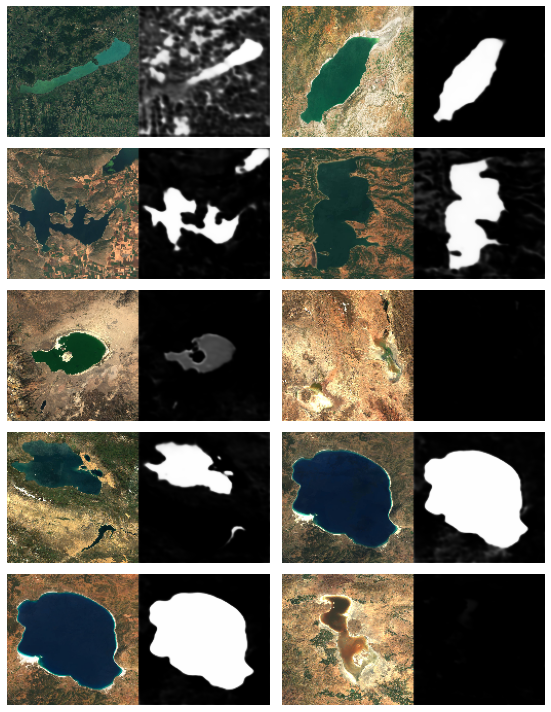

In [0]:
show_combined_plots(X_test, y_pred, BATCH_SIZE, (8, 10))

In [0]:
unet_model.history.history.keys()

dict_keys(['loss', 'mean_iou_imp', 'val_loss', 'val_mean_iou_imp'])

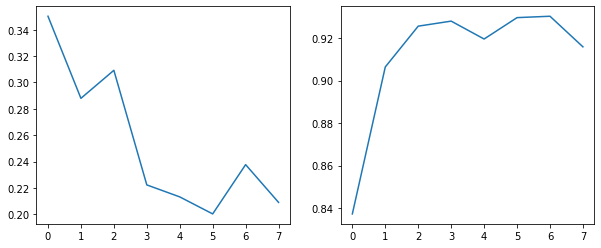

In [0]:
_, axs = plt.subplots(1,2, figsize = (10, 4))
axs[0].plot(unet_model.history.history['val_loss'])
axs[1].plot(unet_model.history.history['val_mean_iou_imp'])